In [1]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import anndata as ad
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
from scripts.utils import load_from_pickle, save_to_pickle
from scipy.stats import fisher_exact

import warnings
warnings.filterwarnings('ignore')
sc.set_figure_params(figsize=(6,6),dpi=120)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kzu1l191 because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:

regions = ['Tumor','Luminal epithelium','Basal epithelium','Club epithelium','Immune','Endothelium','Fibroblast','Muscle']


region_colors_dict = {
    'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
}

In [4]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

# Download the gene lists
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

## He et al. 2021 prostate cancer mets scRNA-seq

### Formatting

In [ ]:

he_2021_dat = pd.read_csv('./sc-reference/he_2021/scp_tpm.tsv',sep = '\t',index_col=0)
he_2021_meta = pd.read_csv('./sc-reference/he_2021/scp_clustering.tsv',sep = '\t')

In [ ]:
he_2021_adata = ad.AnnData(
    X=he_2021_dat.T,
    var=pd.DataFrame(index=he_2021_dat.index),
    obs = he_2021_meta
)
he_2021_adata

In [ ]:
he_2021_adata.layers['tpm_counts'] = he_2021_adata.X.copy()

he_2021_adata.write('./sc-reference/he_2021/adata.h5ad')

### Processing

In [5]:
he_2021_adata = sc.read_h5ad('./sc-reference/he_2021/adata.h5ad')

In [ ]:

sc.pp.filter_genes(he_2021_adata, min_cells=5)

sc.pp.log1p(he_2021_adata)
sc.pp.highly_variable_genes(he_2021_adata,n_top_genes=2000,flavor='seurat_v3')
sc.pp.scale(he_2021_adata)
sc.tl.pca(he_2021_adata, svd_solver='arpack')
sc.pp.neighbors(he_2021_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(he_2021_adata)

In [ ]:
sc.tl.leiden(he_2021_adata,0.5)
he_2021_adata.obs['leiden'].value_counts()

In [ ]:

for k in refined_markers.keys():
    refined_markers[k] = [g for g in refined_markers[k] if g in he_2021_adata.var_names.tolist()]

sc.pl.dotplot(he_2021_adata,var_names=refined_markers,groupby='leiden',figsize=(12,10))

### Subset to include just epithelial cells

In [ ]:
epithelial_clusters = ['2','3','4','7','9','14','15','18']
epithelial_idents = he_2021_adata[he_2021_adata.obs['leiden'].isin(epithelial_clusters)].obs_names
he_2021_adata_epithelial = sc.read_h5ad('./sc-reference/he_2021/adata.h5ad')[epithelial_idents]
he_2021_adata_epithelial

In [ ]:
# Epithelial cell subclustering
sc.pp.filter_genes(he_2021_adata_epithelial, min_cells=5)

sc.pp.log1p(he_2021_adata_epithelial)
sc.pp.highly_variable_genes(he_2021_adata_epithelial,n_top_genes=2000,flavor='seurat_v3')
sc.pp.scale(he_2021_adata_epithelial)
sc.tl.pca(he_2021_adata_epithelial, svd_solver='arpack')
sc.pp.neighbors(he_2021_adata_epithelial, n_neighbors=10, n_pcs=40)
sc.tl.umap(he_2021_adata_epithelial)

In [ ]:
sns.set_theme(style='white')
sc.tl.leiden(he_2021_adata_epithelial,0.5)
sc.pl.umap(he_2021_adata_epithelial,color='leiden')

### Calculate DEGs

In [ ]:
clusters = he_2021_adata_epithelial.obs['leiden'].cat.categories.tolist()

sc.tl.rank_genes_groups(he_2021_adata_epithelial,groupby='leiden',method='wilcoxon')


In [ ]:
enrichment_results_pvals = pd.DataFrame(data=np.nan,index=regions,columns=clusters)
enrichment_results_expression = pd.DataFrame(data=np.nan,index=regions,columns=clusters)

for reg in regions:

    #for cluster_name in clusters:
    for cluster_name in clusters:

        all_genes_marker_check = check_top_markers(reg,p_thresh=1.1)['gene'].tolist()
        n_universe = len(np.intersect1d(all_genes_marker_check,he_2021_adata_epithelial.var_names.tolist()))

        region_markers = check_top_markers(reg)['gene'].tolist()
        n_region_markers = len(region_markers)

        df = sc.get.rank_genes_groups_df(he_2021_adata_epithelial,group=cluster_name)
        cluster_markers = df[(df['scores'] >= 0) & (df['pvals_adj']< 0.05)]['names'].tolist()
        n_cluster_markers = len(cluster_markers)


        cluster_region_marker_overlap = list(np.intersect1d(region_markers,cluster_markers))

        a = len(cluster_region_marker_overlap) # Overlapping genes
        b = len([g for g in cluster_markers if g not in region_markers]) # YES cluster markers NO region markers
        c = len([g for g in region_markers if g not in cluster_markers]) # NO cluster markers YES region markers
        d = n_universe - a -b -c # NO either (rest of the genes)
        arr = np.array([a,b,c,d]).reshape(2,2)
        stat, pval = fisher_exact(arr,alternative='greater')

        # print(cluster_name)
        
        if pval < 0.05:
            
            enrichment_results_pvals.loc[reg,cluster_name] = pval
            enrichment_results_expression.loc[reg,cluster_name]=  he_2021_adata_epithelial[he_2021_adata_epithelial.obs['leiden'] == cluster_name,cluster_region_marker_overlap].layers['tpm_counts'].copy().mean()


            print(str(arr) + ' stat: {:.2f} p-value:{:.1e} !!'.format(stat,pval))
            print(cluster_region_marker_overlap)
        else:
            print(str(arr) + ' stat: {:.2f} p-value:{:.1e}'.format(stat,pval))
        print('')


In [ ]:
enrichment_results_pvals

In [ ]:
#sns.set_theme(style='whitegrid')
sns.set_theme(style='white')

plot_df = -np.log2(enrichment_results_pvals)
plot_df = plot_df.reset_index().melt('index').rename(columns={'value':'pval'})
plot_df['expression'] = np.log2(enrichment_results_expression.reset_index().melt('index')['value'])


plot_df['pval'] = pd.cut(plot_df['pval'],bins=5,labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
#plot_df['expression'] = pd.cut(plot_df['expression'],bins=5,labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

fig,ax = plt.subplots(figsize=(9,3))
sns.scatterplot(
    plot_df,
    x='variable',
    y='index',
    size='pval',
    hue='expression',
    #legend=False,
    sizes=(400,100),
    palette='Reds'
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.gca().spines['left'].set_visible(False)  # Turn off the left spine
plt.gca().spines['right'].set_visible(False)  # Turn off the right spine
plt.gca().spines['top'].set_visible(False)  # Turn off the top spine
plt.gca().spines['bottom'].set_visible(False)  # Turn off the bottom spine

plt.tight_layout()
#plt.savefig('plots/he2021_metastases_cluster_marker_region_marker_overlap.pdf')

In [ ]:
sns.set_theme(style='white')
sc.pl.umap(he_2021_adata,color='leiden',palette='tab20')
plt.tight_layout()
plt.savefig('plots/he2021_metastases_clustering_umap.pdf')

## Plotting gene set markers on the data

In [6]:
he_2021_adata = sc.read_h5ad('./sc-reference/he_2021/adata.h5ad')

In [7]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

# Download the gene listsa
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T
marker_genes = check_top_markers('Club epithelium')['gene'].tolist()


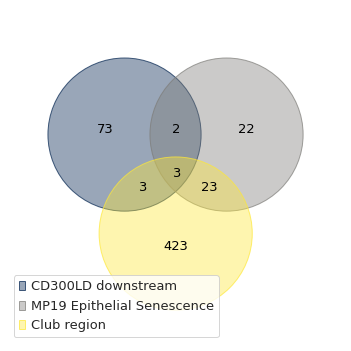

In [9]:
sns.set_theme(style='white')
sns.set_palette(sns.color_palette([region_colors_dict['Club epithelium']]))
from venn import venn

gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T
gene_set_df.rename(columns={'NLR associated':'High NLR-associated'},inplace=True)

set1_name = 'CD300LD downstream'
set1 = set(gene_set_df[set1_name].dropna())


set2_name = 'MP19 Epithelial Senescence'
set2 = set(gene_set_df[set2_name].dropna())

set3_name = 'Club region'
set3 = set(marker_genes)

venn_data = {
            set1_name: set1,
            set2_name: set2,
            set3_name: set3,
            }
fig,ax = plt.subplots(figsize=(6,6))
# Create the Venn diagram
venn(venn_data,
    ax=ax,
    cmap='cividis',
    legend_loc='best'
    #legend_loc=None

)
#plt.savefig('plots/score_correlations/venn_'+set1_name+'_'+set2_name+'_'+set3_name+'_no_title.pdf')
plt.savefig('plots/score_correlations/venn_'+set1_name+'_'+set2_name+'_'+set3_name+'.pdf')
# Display the diagram
plt.show()

### Plot expression in the He et al. 2021 dataset (small set of genes)

In [35]:
genes = [
    'TACSTD2','CHI3L1','CEACAM1','SLPI','LCN2','LTF','S100P','S100A8','S100A9','SERPINB1','ANXA1'
]

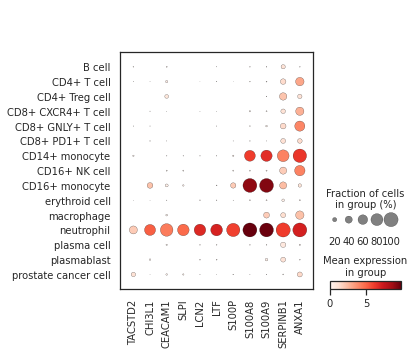

In [42]:
sns.set_theme(style='white')
#fig,ax = plt.subplots(figsize=(5,5))
fig,ax = plt.subplots(figsize=(5,5))
sc.pl.dotplot(he_2021_adata,var_names=genes,groupby='group',ax=ax,show=False,log=True)

plt.savefig('plots/he_2021_metastases_club_episen_club_cd300ld_markers_dotplot.pdf',transparent=True)

plt.show()

In [43]:
[print(g) for g in genes]

TACSTD2
CHI3L1
CEACAM1
SLPI
LCN2
LTF
S100P
S100A8
S100A9
SERPINB1
ANXA1


[None, None, None, None, None, None, None, None, None, None, None]

### Plot expression in the He et al. 2021 dataset (club senescence)

In [ ]:
genes = [
    'AGR2','AQP3','CEACAM6','CLDN4','CLDN7','CRABP2','CXCL17','ELF3','GPRC5A',
    'IGFBP3','KRT13','KRT16','KRT17','KRT7','LCN2','MAL2','MUC4','PDZK1IP1',
    'PI3','PRSS22','S100A9','S100P','SAA1','SERPINB1','SLPI','TACSTD2','WFDC2'
]

In [ ]:
sns.set_theme(style='white')
fig,ax = plt.subplots(figsize=(9,5))
sc.pl.dotplot(he_2021_adata,var_names=genes,groupby='group',ax=ax,show=False,log=True)

plt.savefig('plots/he_2021_metastases_club_senescence_dotplot.pdf',transparent=True)

plt.show()

### Region markers dotplot

In [ ]:
region_degs_dict = load_from_pickle('data/region_gene_markers_signif_degs_240128.pkl')
marker_genes_for_hmap = ['MMP7','PIGR','CP','SCGB1A1'] + genes.tolist()

In [ ]:
# Create the dotplot structure

plot_df = pd.DataFrame()
for region in regions:
    degs = region_degs_dict[region]
    n_samples = len(degs['sample'].unique())
    
    degs = degs[degs['names'].isin(marker_genes_for_hmap)]
    
    mean_lfc_list = []
    proportion_degs_list = []

    for gene in marker_genes_for_hmap:

        if gene in degs['names'].values:
            mean_lfc = degs[degs['names'] == gene]['logfoldchanges'].mean()
            proportion_degs = degs['names'].value_counts()[gene] / n_samples
            mean_lfc_list.append(mean_lfc)
            proportion_degs_list.append(proportion_degs)
        
        else:
            mean_lfc_list.append(np.nan)
            proportion_degs_list.append(0)
    
    df = pd.DataFrame({'mean_logfoldchange': mean_lfc_list,'pct_deg_in': proportion_degs_list, 'region': region},index = marker_genes_for_hmap)
    plot_df = pd.concat([plot_df,df],axis=0)

plot_df['genes'] = plot_df.index.astype(str)

plot_df.loc[plot_df['pct_deg_in']==0,'pct_deg_in'] = np.nan

In [ ]:

# Create the dotplot
sns.set(style='white')

width = 8
height = 4

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions)*2)+2,2)[::-1])


# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions,yticks_list)))
sns.scatterplot(x='genes', y='region_y', size='pct_deg_in', hue='mean_logfoldchange', 
                data=plot_df, sizes=(40, 400), palette='Reds', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.show()
